# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>


In [1]:
import pandas as pd
from collections import Counter
from openpyxl import Workbook
df = pd.read_excel("marketing_case_v.0.7.xlsx", sheet_name="B2", engine = 'openpyxl')
df.tail(10)


,ID Микросегмент,Дата просмотра рекламы,"Кол-во пользователей, просмотревших рекламу",Кол-во просмотров рекламы
499990,499991,2020-02-24,20,21
499991,499992,2020-08-05,5,29
499992,499993,2020-08-31,24,5
499993,499994,2020-08-05,4,9
499994,499995,2020-08-03,11,29
499995,499996,2020-12-04,27,1
499996,499997,2020-03-23,26,3
499997,499998,2020-10-22,5,12
499998,499999,2020-04-20,25,19
499999,500000,2020-12-06,26,10


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   ID Микросегмент                              500000 non-null  int64 
 1   Дата просмотра рекламы                       500000 non-null  object
 2   Кол-во пользователей, просмотревших рекламу  500000 non-null  int64 
 3   Кол-во просмотров рекламы                    500000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 15.3+ MB


Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 0'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>


In [4]:
QI = [
    'Дата просмотра рекламы',
    'Кол-во пользователей, просмотревших рекламу',
    ]
SI = ['Кол-во просмотров рекламы']

In [5]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  return min(aggregrate)
print(' k-anonymity = ' + str(k_anonymous(df, QI )))

 k-anonymity = 21


#### Графики подсчета этих типов данных показаны ниже.

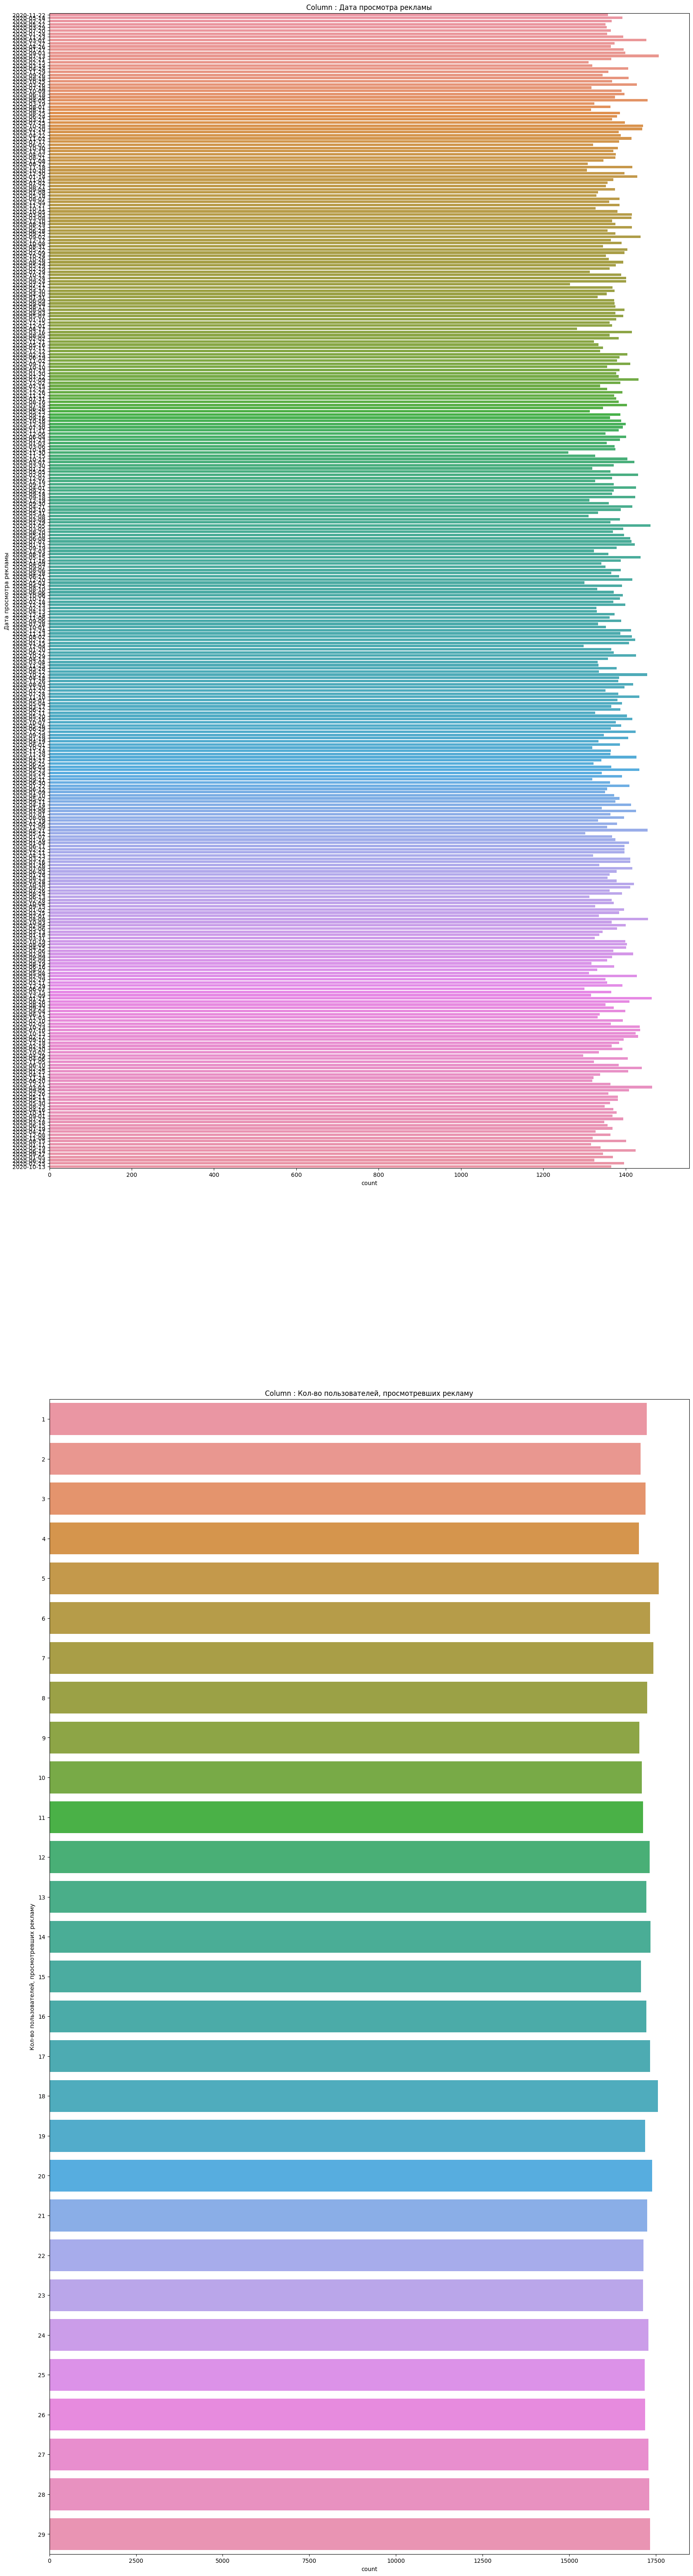

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = QI

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])

#### Количество повторных значений

In [7]:
def quantity_qi(arg):
    quantity = Counter(df[arg])
    dic_quan = dict(quantity)
    
    for idx, item in enumerate(dic_quan.items(),1):
        if(arg == 'Дата просмотра рекламы'):
            ws['A' + str(idx + 1)] = f"{item[0]}:{item[1]}"
            ws['A1'] = f"{arg}"
        elif(arg == 'Кол-во пользователей, просмотревших рекламу'):
            ws['B' + str(idx + 1)] = f"{item[0]}:{item[1]}"
            ws['B1'] = f"{arg}"

In [8]:
wb = Workbook()
ws = wb.create_sheet("B2")
for arg in QI:
    quantity_qi(arg)
wb.save('quantity.xlsx')
df2 = pd.read_excel('quantity.xlsx', sheet_name="B2", engine = 'openpyxl')
df2.head(10)

,Дата просмотра рекламы,"Кол-во пользователей, просмотревших рекламу"
0,2020-11-22:1357,3:17194
1,2020-05-14:1392,19:17186
2,2020-02-27:1366,27:17277
3,2020-05-27:1351,21:17242
4,2020-03-29:1354,14:17336
5,2020-07-20:1364,9:17019
6,2020-01-24:1355,10:17097
7,2020-11-23:1394,1:17234
8,2020-03-01:1450,17:17327
9,2020-12-27:1373,16:17224
